In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import sys
import torch
from   torch.utils import data

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from data.data_utils import Dataset

/home/ilze/virtualenv/venv3.8/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ilze/virtualenv/venv3.8/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## Compare Mov MNIST results

### load data

In [4]:
data_path = '../data/mov_mnist/mov_mnist-data.pkl'
Ntrain = 1500
Nvalid = 50
device = 'cpu'
dtype = torch.float64
batch_size = 25
shuffle = False
num_workers = 0

In [5]:
X = torch.load(data_path)
X = X.to(device).to(dtype)
Xtr = X[:Ntrain]
Xtest = X[Ntrain:]

FileNotFoundError: [Errno 2] No such file or directory: '../data/mov_mnist/mov_mnist-data.pkl'

In [ ]:
params = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'drop_last': True}
trainset = Dataset(Xtr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(Xtest)
testset  = data.DataLoader(testset, **params)

### load models

In [6]:
from model.core.invodevae import INVODEVAE
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.mlp import MLP
from model.core.inv_enc import INV_ENC

##### Node + inv + contrastive (latent dim 16)

In [7]:
T_in = 5
T_inv = 15
ode_latent_dim = 12
inv_latent_dim = 16
order = 1 
Nobj = 2
D_in  = ode_latent_dim// Nobj
D_out = ode_latent_dim// Nobj
solver = 'euler'
use_adjoint = False
frames = 5
dt = 0.1
aug = False
Nobj = 2
task ='mov_mnist'
n_filt = 16
num_layers = 2 
num_hidden = 200
rnn_hidden = 10
decoder_H = 100
dec_act = 'relu'
cnn_arch = 'dcgan'
last_layer_gp  = None

In [8]:
node_inv_contr = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


In [9]:
node_inv_contr.to(device)
fname = '../results/mov_mnist/17_01_2023-18:04/invodevae.pth'
node_inv_contr.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv_contr.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../results/mov_mnist/17_01_2023-18:04/invodevae.pth'

##### Node + inv + contrastive (latent dim 32)

In [9]:
inv_latent_dim = 32

In [10]:
node_inv_contr32 = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


In [11]:
node_inv_contr32.to(device)
fname = '../results/mov_mnist/17_01_2023-18:06/invodevae.pth'
node_inv_contr32.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv_contr32.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=6, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=6, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): DCGAN64Encoder(
      (sp): Softplus(beta=1, threshold=20)
      (conv): ModuleList(
        (0): Sequential(
          (0): Conv2d(5, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

##### Node + inv (to be implemented)

In [14]:
node_inv = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        num_observations = Ntrain,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [15]:
node_inv.to(device)
fname = 'results/rot_mnist/17_01_2023-18:03/invodevae.pth'
node_inv.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_inv.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### Node (to be implemented)

In [16]:
T_in = 1
inv_latent_dim=0
node_base= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver=solver, use_adjoint=use_adjoint),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [17]:
node_base.to(device)
fname = '../results/mov_mnist/17_01_2023-18:06/invodevae.pth'
node_base.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_base.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=10, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): PositionEncoderCNN(
      (sp): Softplus(beta=1, threshold=20)
      (cnn): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6):

##### plot results

In [12]:
def plot_C(C):
    '''
    C - embeddings L, N, T, q
    N, T, q - size of tensors
    '''
    C = C.mean(0) if C.ndim==4 else C
    N_,T_,q_ = C.shape
    C = C.reshape(N_*T_,q_) # NT,q

    diff = C.unsqueeze(0) - C.unsqueeze(1) # NT,NT,q pairwise diffs
    dist = diff.pow(2).sum(2).sqrt()

    plt.figure(1,(12,9))
    plt.imshow(dist.detach().cpu().numpy())
    plt.colorbar()

    
    C_ = C / C.pow(2).sum(1,keepdim=True).sqrt() # normalized features
    theta = (C_.unsqueeze(0) * C_.unsqueeze(1)).sum(2) # NT,NT angle between features

    plt.figure(2,(12,9))
    plt.imshow(theta.detach().cpu().numpy())
    plt.colorbar()

In [13]:
test_batch = next(iter(testset)).to(device)

In [14]:
from model.misc.plot_utils import plot_mnist, plot_latent_traj

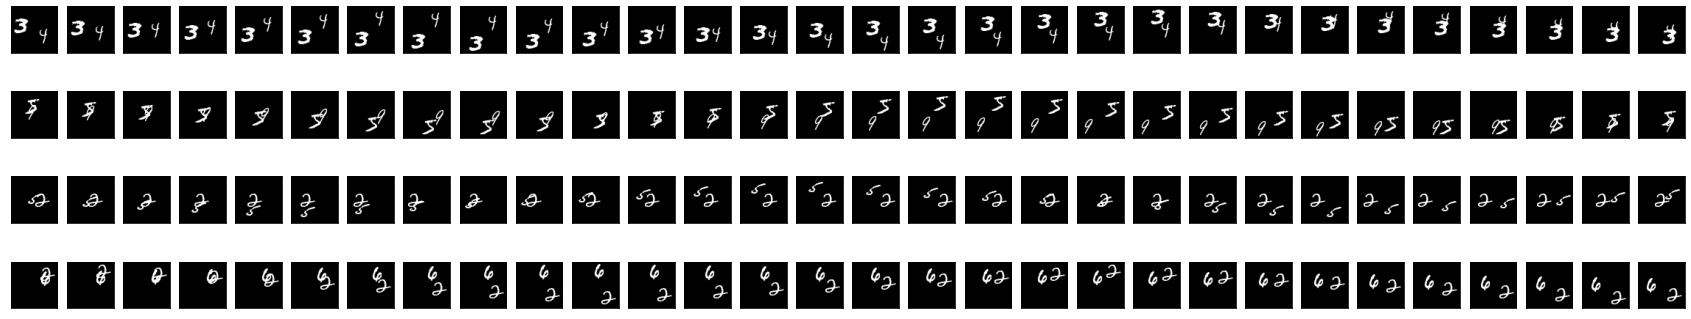

In [15]:
plot_mnist(test_batch[:2], test_batch[2:4], show=True)

In [16]:
plotL= 5
forecast_te = 1
subsample = 4


##### Node+ inv +cont

In [17]:
Xrec_te, ztL_te, _, _, C_full = node_inv_contr(test_batch[:subsample],   L=plotL, T_custom=forecast_te*test_batch.shape[1])

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


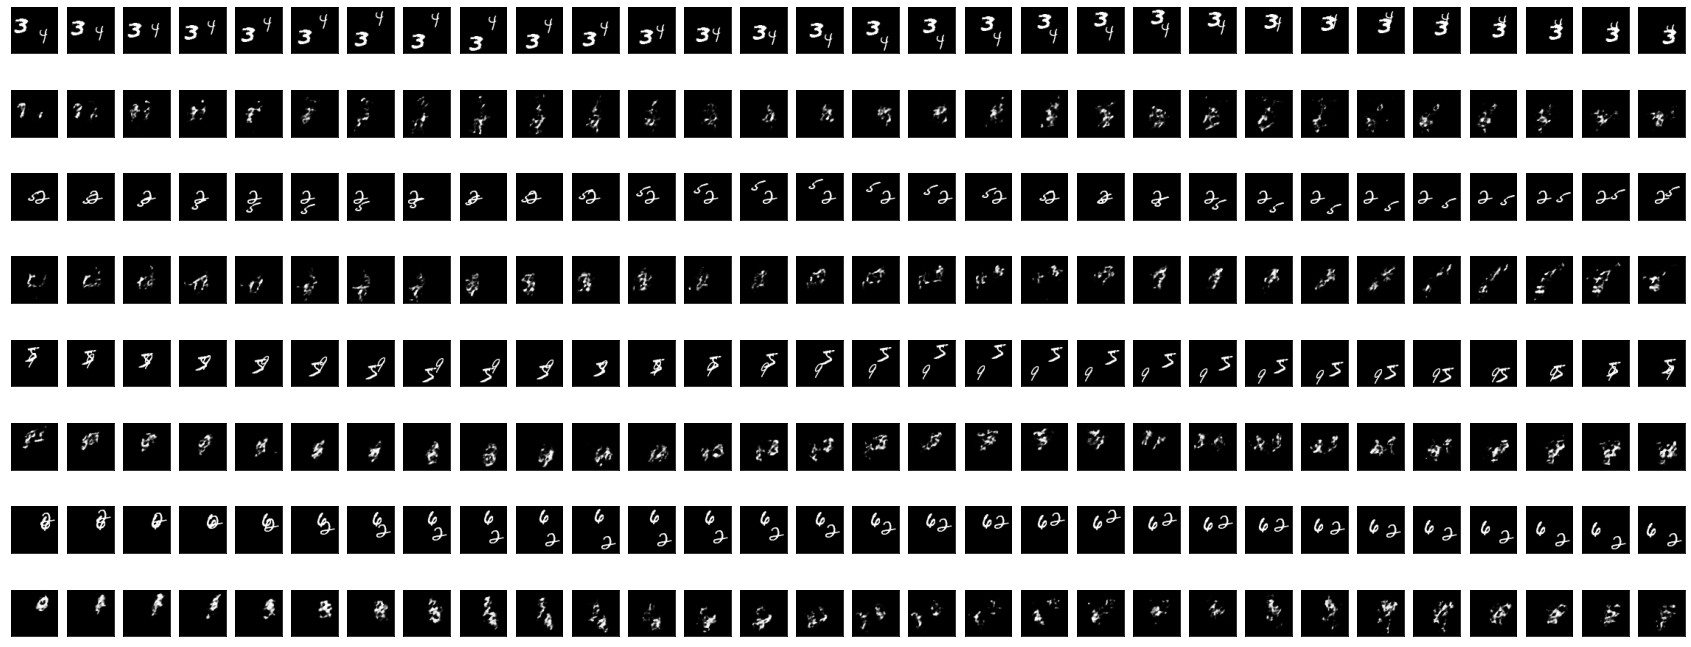

In [18]:
plot_mnist(test_batch[:subsample], Xrec_te[:subsample], show=True)

IndexError: index 4 is out of bounds for axis 1 with size 4

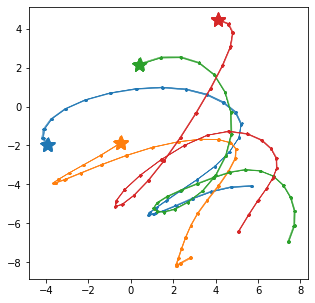

In [19]:
plot_latent_traj(ztL_te, show=True)

In [20]:
Xrec_te, ztL_te, _, _, C_full = node_inv_contr32(test_batch[:subsample],   L=plotL, T_custom=forecast_te*test_batch.shape[1])

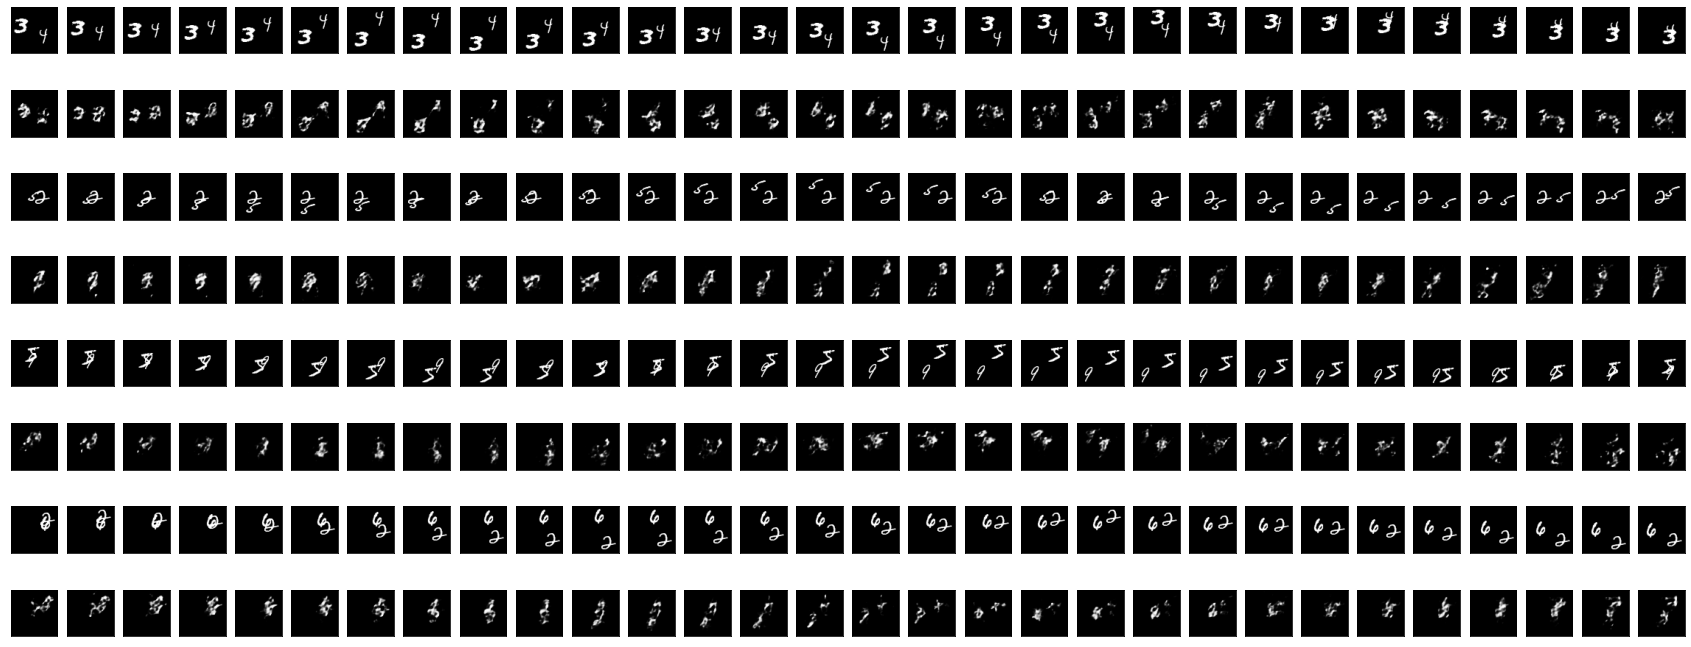

In [21]:
plot_mnist(test_batch[:subsample], Xrec_te[:subsample], show=True)

IndexError: index 4 is out of bounds for axis 1 with size 4

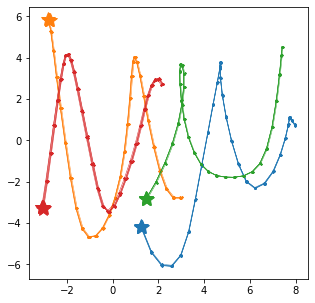

In [22]:
plot_latent_traj(ztL_te, show=True)

##### Node+ inv

In [40]:
Xrec_te, ztL_te, _, _, C_inv = node_inv(test_batch,   L=plotL, T_custom=forecast_te*test_batch.shape[1])

tin 1
x torch.Size([25, 16, 1, 28, 28])


In [ ]:
plot_mnist(test_batch[:subsample], Xrec_te[:subsample], show=True)

In [ ]:
plot_latent_traj(ztL_te[:subsample], show=True)

##### Node 

In [43]:
Xrec_te, ztL_te, _, _, C_base = node_base(test_batch,   L=plotL, T_custom=forecast_te*test_batch.shape[1])

tin 1
x torch.Size([25, 16, 1, 28, 28])


In [ ]:
plot_mnist(test_batch[:subsample], Xrec_te[:subsample], show=True)

In [ ]:
plot_latent_traj(ztL_te[:subsample], show=True)

Contrastive Matrix Z

In [ ]:
plot_C(C_full)

In [ ]:
plot_C(C_inv)